<a href="https://colab.research.google.com/github/jatin-reddy/CNNs-for-Computer-Vision/blob/main/CNN_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moritzm00/utkface-cropped")

print("Path to dataset files:", path)

100%|██████████| 116M/116M [00:01<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1


Skipping file with ValueError: 61_1_20170109150557335.jpg.chip.jpg
Skipping file with ValueError: 39_1_20170116174525125.jpg.chip.jpg
Skipping file with ValueError: 61_1_20170109142408075.jpg.chip.jpg


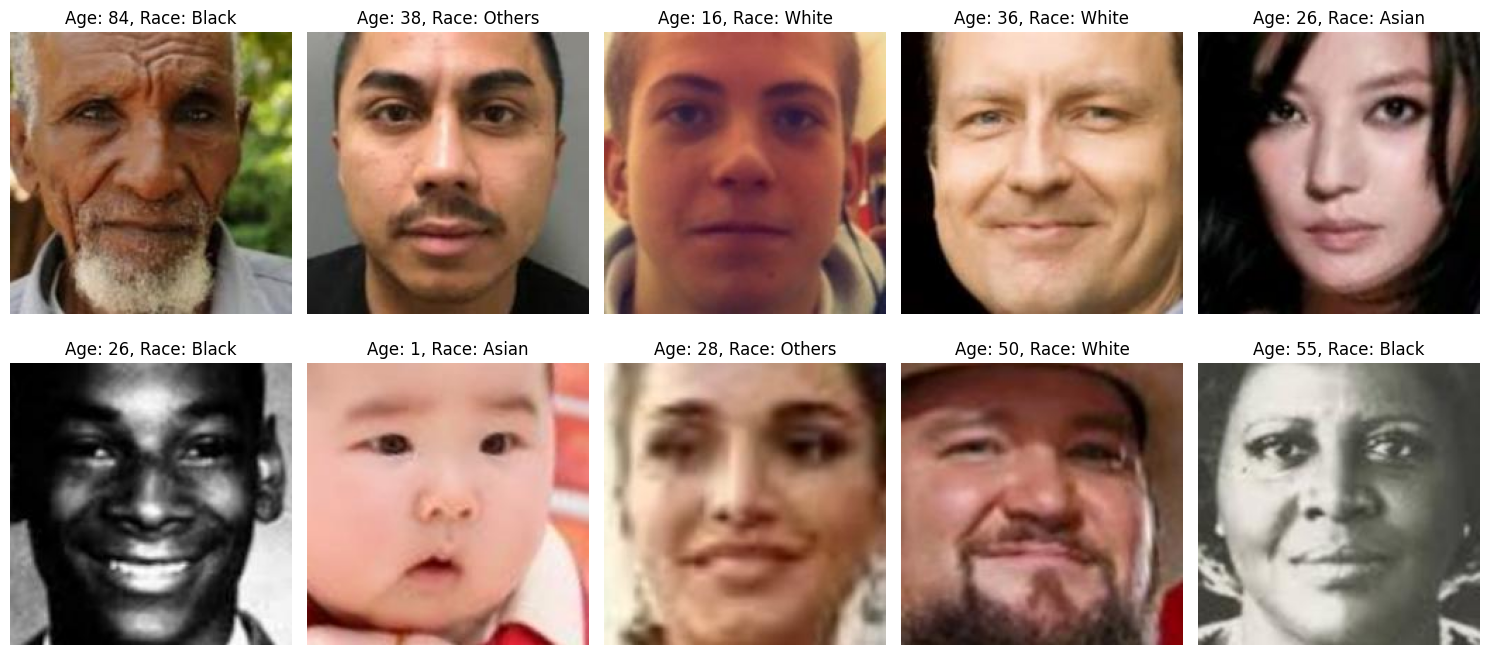

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

dataset_path = "/root/.cache/kagglehub/datasets/moritzm00/utkface-cropped/versions/1"
dataset_path = os.path.join(dataset_path, "UTKFace")

# image_paths, age, gender, race
image_paths = []
age_list = []
gender_list = []
race_list = []

race_dict = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

gender_dict = {
    0: 'Male',
    1: 'Female',
}

for images in os.listdir(dataset_path):
    if images.endswith(".jpg"):
        try:
            image_name = os.path.basename(images)
            image_path = os.path.join(dataset_path, image_name)
            image_labels = image_name.split('_')

            age = int(image_labels[0])
            gender = int(image_labels[1])
            race = int(image_labels[2])

            age_list.append(age)
            gender_list.append(gender)
            race_list.append(race)
            image_paths.append(image_path)

        except ValueError:
            print(f"Skipping file with ValueError: {image_name}")
        except IndexError:
            print(f"Skipping file with IndexError: {image_name}")
        except Exception as e:
            print(f"Skipping file with unknown error '{e}': {image_name}")

## Displaying random images with ethnicity and age
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i in range(10):
    idx = random.randint(0, len(image_paths) - 1)

    img_path = image_paths[idx]
    age = age_list[idx]
    race = race_list[idx]

    ax = axes[i // 5, i % 5]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Age: {age}, Race: {race_dict.get(race, 'Unknown')}")
    ax.axis('off')

plt.tight_layout()
plt.show()

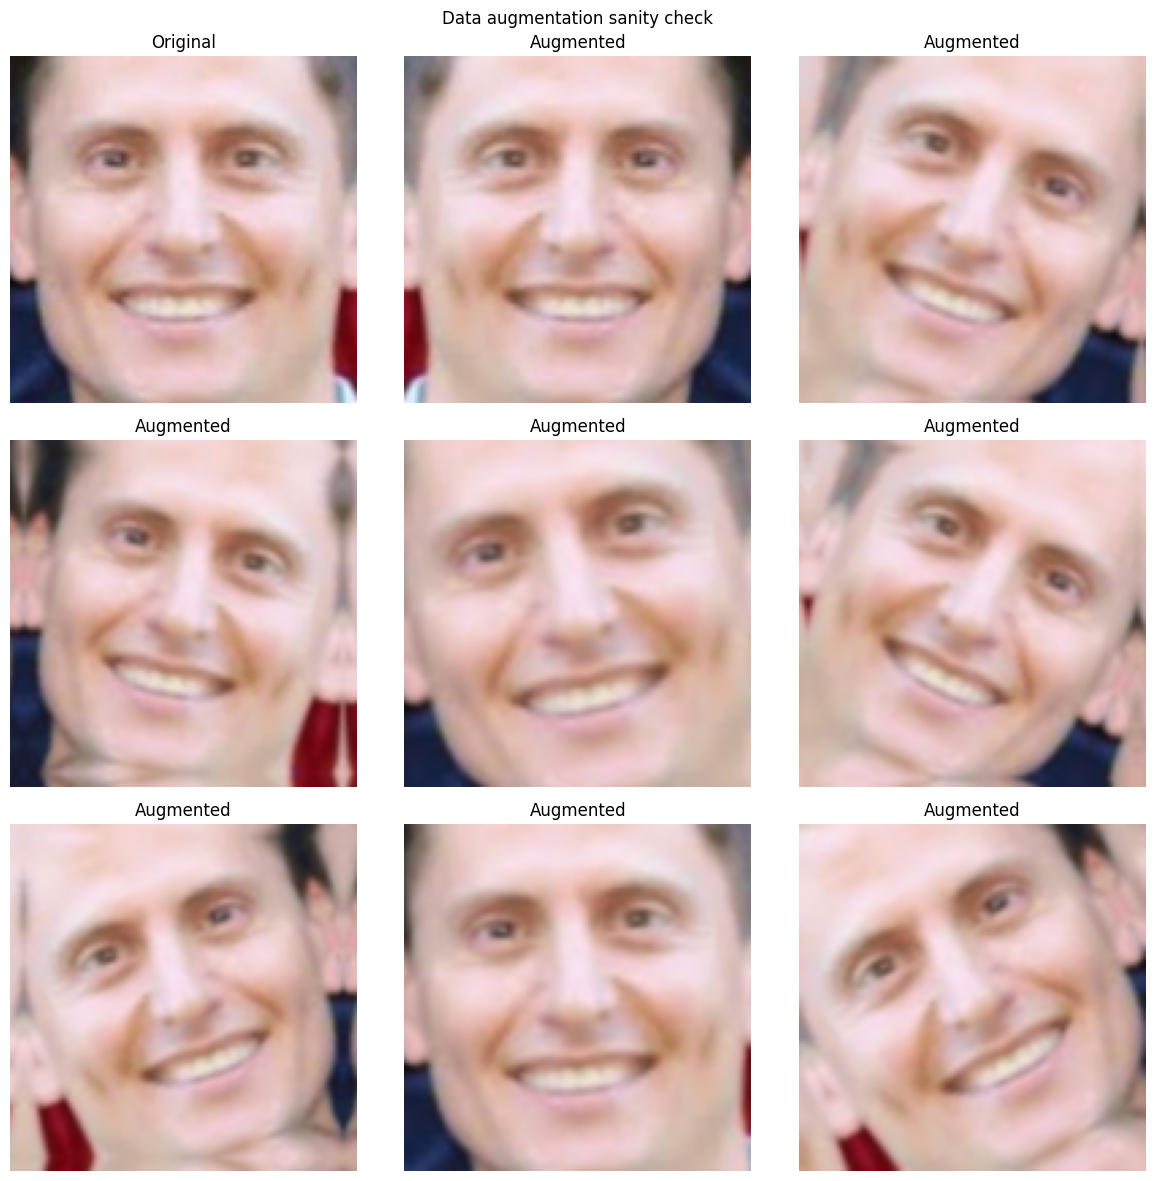

In [3]:
# Data Augmentation
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

IMG_SIZE = 128
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #layers.RandomBrightness(factor=0.2),
        #layers.RandomContrast(factor=0.2),
    ],
    name="data_augmentation"
)

img = tf.io.read_file(image_paths[0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
img_batch = tf.expand_dims(img, 0)

plt.figure(figsize=(12, 12))
ax = plt.subplot(3, 3, 1)
plt.imshow(img.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

for i in range(8):
    ax = plt.subplot(3, 3, i + 2)
    augmented_batch = data_augmentation(img_batch, training=True)
    augmented_img = augmented_batch[0]

    plt.imshow(augmented_img.numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Data augmentation sanity check", fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
# image_paths, age_list, gender_list, race_list

max_age = 116.0
age_list_normalized = [age / max_age for age in age_list]

# Test-Val_test split: 60% Train, 20% Val, 20% Test

# 60% Train, 40% Temp
(train_paths, temp_paths,
 train_ages, temp_ages,
 train_gender, temp_gender,
 train_races, temp_races) = train_test_split(
    image_paths,
    age_list_normalized,
    gender_list,
    race_list,
    test_size=0.4,
    random_state=42,
    stratify=race_list
)

# Temp to 20% Val, 20% Test
(val_paths, test_paths,
 val_ages, test_ages,
 val_gender, test_gender,
 val_races, test_races) = train_test_split(
    temp_paths,
    temp_ages,
    temp_gender,
    temp_races,
    test_size=0.5,
    random_state=42,
    stratify=temp_races
)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(race_list)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_races
)

race_weights_dict = dict(zip(classes, weights))
race_weights_dict = {int(i): float(j) for i, j in race_weights_dict.items()}

print("Class Weights for Ethnicity:")
print(race_weights_dict)

train_race_weights = [race_weights_dict[label] for label in train_races]
val_race_weights = [1.0] * len(val_paths)
test_race_weights = [1.0] * len(test_paths)


Class Weights for Ethnicity:
{0: 0.47041508185877295, 1: 1.0473490427098675, 2: 1.380873786407767, 3: 1.1927044025157232, 4: 2.80256157635468}


In [6]:
IMG_SIZE = 128
BATCH_SIZE = 64
# function for image loading and preprocessing
def load_preprocess(image_path, age_label, gender_label, race_label, race_weight):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0

    """
    labels = {
        "age_output": age_label,
        "gender_output": gender_label,
        "ethnicity_output": race_label
    }

    weights = {
        "age_output": 1.0,
        "gender_output": 1.0,
        "ethnicity_output": race_weight ### key error
    }
    """
    labels = (age_label, gender_label, race_label)
    # (age weight, genderweight, race weight)
    weights = (1.0, 1.0, race_weight)

    return img, labels, weights ### bug (forgot to add weights)

# data loading pipepline
def data_pipeline(paths, ages, gender, races, race_weights, is_training=True):

    df = tf.data.Dataset.from_tensor_slices((paths, ages, gender, races, race_weights))

    df = df.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        df = df.shuffle(buffer_size=1000)

    df = df.batch(BATCH_SIZE)
    df = df.prefetch(buffer_size=tf.data.AUTOTUNE)

    return df

train_df = data_pipeline(train_paths, train_ages, train_gender, train_races, train_race_weights)
val_df = data_pipeline(val_paths, val_ages, val_gender, val_races, val_race_weights, is_training=False)
test_df = data_pipeline(test_paths, test_ages, test_gender, test_races, test_race_weights, is_training=False)

We can clearly see that an earlier simple model architecture (even with class_weight adjustments, loss_weight adjustments and an addition of batch normalisation) isn't learning on ethnicities. So, all of these point to a problem in the model architecture itself. Let's change things up. (Till here, I thought the model architecture was the issue)

Update:
From last commit, through trial and error it was found that
sample_weights weren't passed in the data pipeline which uncovered a bug in this section (tuples instead of dict was passed to solve this).

Secondly, when I normalising pixels/255 and then passing Random brightness and Random Contrast in the data augmentation step, the model was getting pure white/black images because of the 0.2 shift in (0,1) range.

In [ ]:
keras.utils.clear_session()

# Model 1: simple_model.keras

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

age_output = layers.Dense(1, activation='sigmoid', name='age_output')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(x)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'age_output': 'mean_squared_error',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },
    loss_weights={'age_output': 1.0, 'gender_output': 1.0, 'ethnicity_output': 1.0}
)

print("Starting Final Training Run...")
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='simple_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(
    train_df,
    epochs=40,
    validation_data=val_df,
    callbacks=[early_stopping, model_checkpoint]
)

Starting Final Training Run...
Epoch 1/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - age_output_loss: 0.0339 - age_output_mean_absolute_error: 0.1415 - ethnicity_output_accuracy: 0.3393 - ethnicity_output_loss: 1.5253 - gender_output_accuracy: 0.6274 - gender_output_loss: 0.6401 - loss: 2.1993 - val_age_output_loss: 0.0613 - val_age_output_mean_absolute_error: 0.1958 - val_ethnicity_output_accuracy: 0.1578 - val_ethnicity_output_loss: 2.2986 - val_gender_output_accuracy: 0.4929 - val_gender_output_loss: 1.0018 - val_loss: 3.3603
Epoch 2/40
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - age_output_loss: 0.0253 - age_output_mean_absolute_error: 0.1237 - ethnicity_output_accuracy: 0.4149 - ethnicity_output_loss: 1.4229 - gender_output_accuracy: 0.6962 - gender_output_loss: 0.5776 - loss: 2.0258 - val_age_output_loss: 0.0418 - val_age_output_mean_absolute_error: 0.1562 - val_ethnicity_output_accuracy: 0.2767 - val_ethnicity_output_loss: 1.7180 - val_gender_output_accuracy: 0.6092 - val_g

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 1,371,863 (5.23 MB)

 Trainable params: 456,967 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 913,936 (3.49 MB)

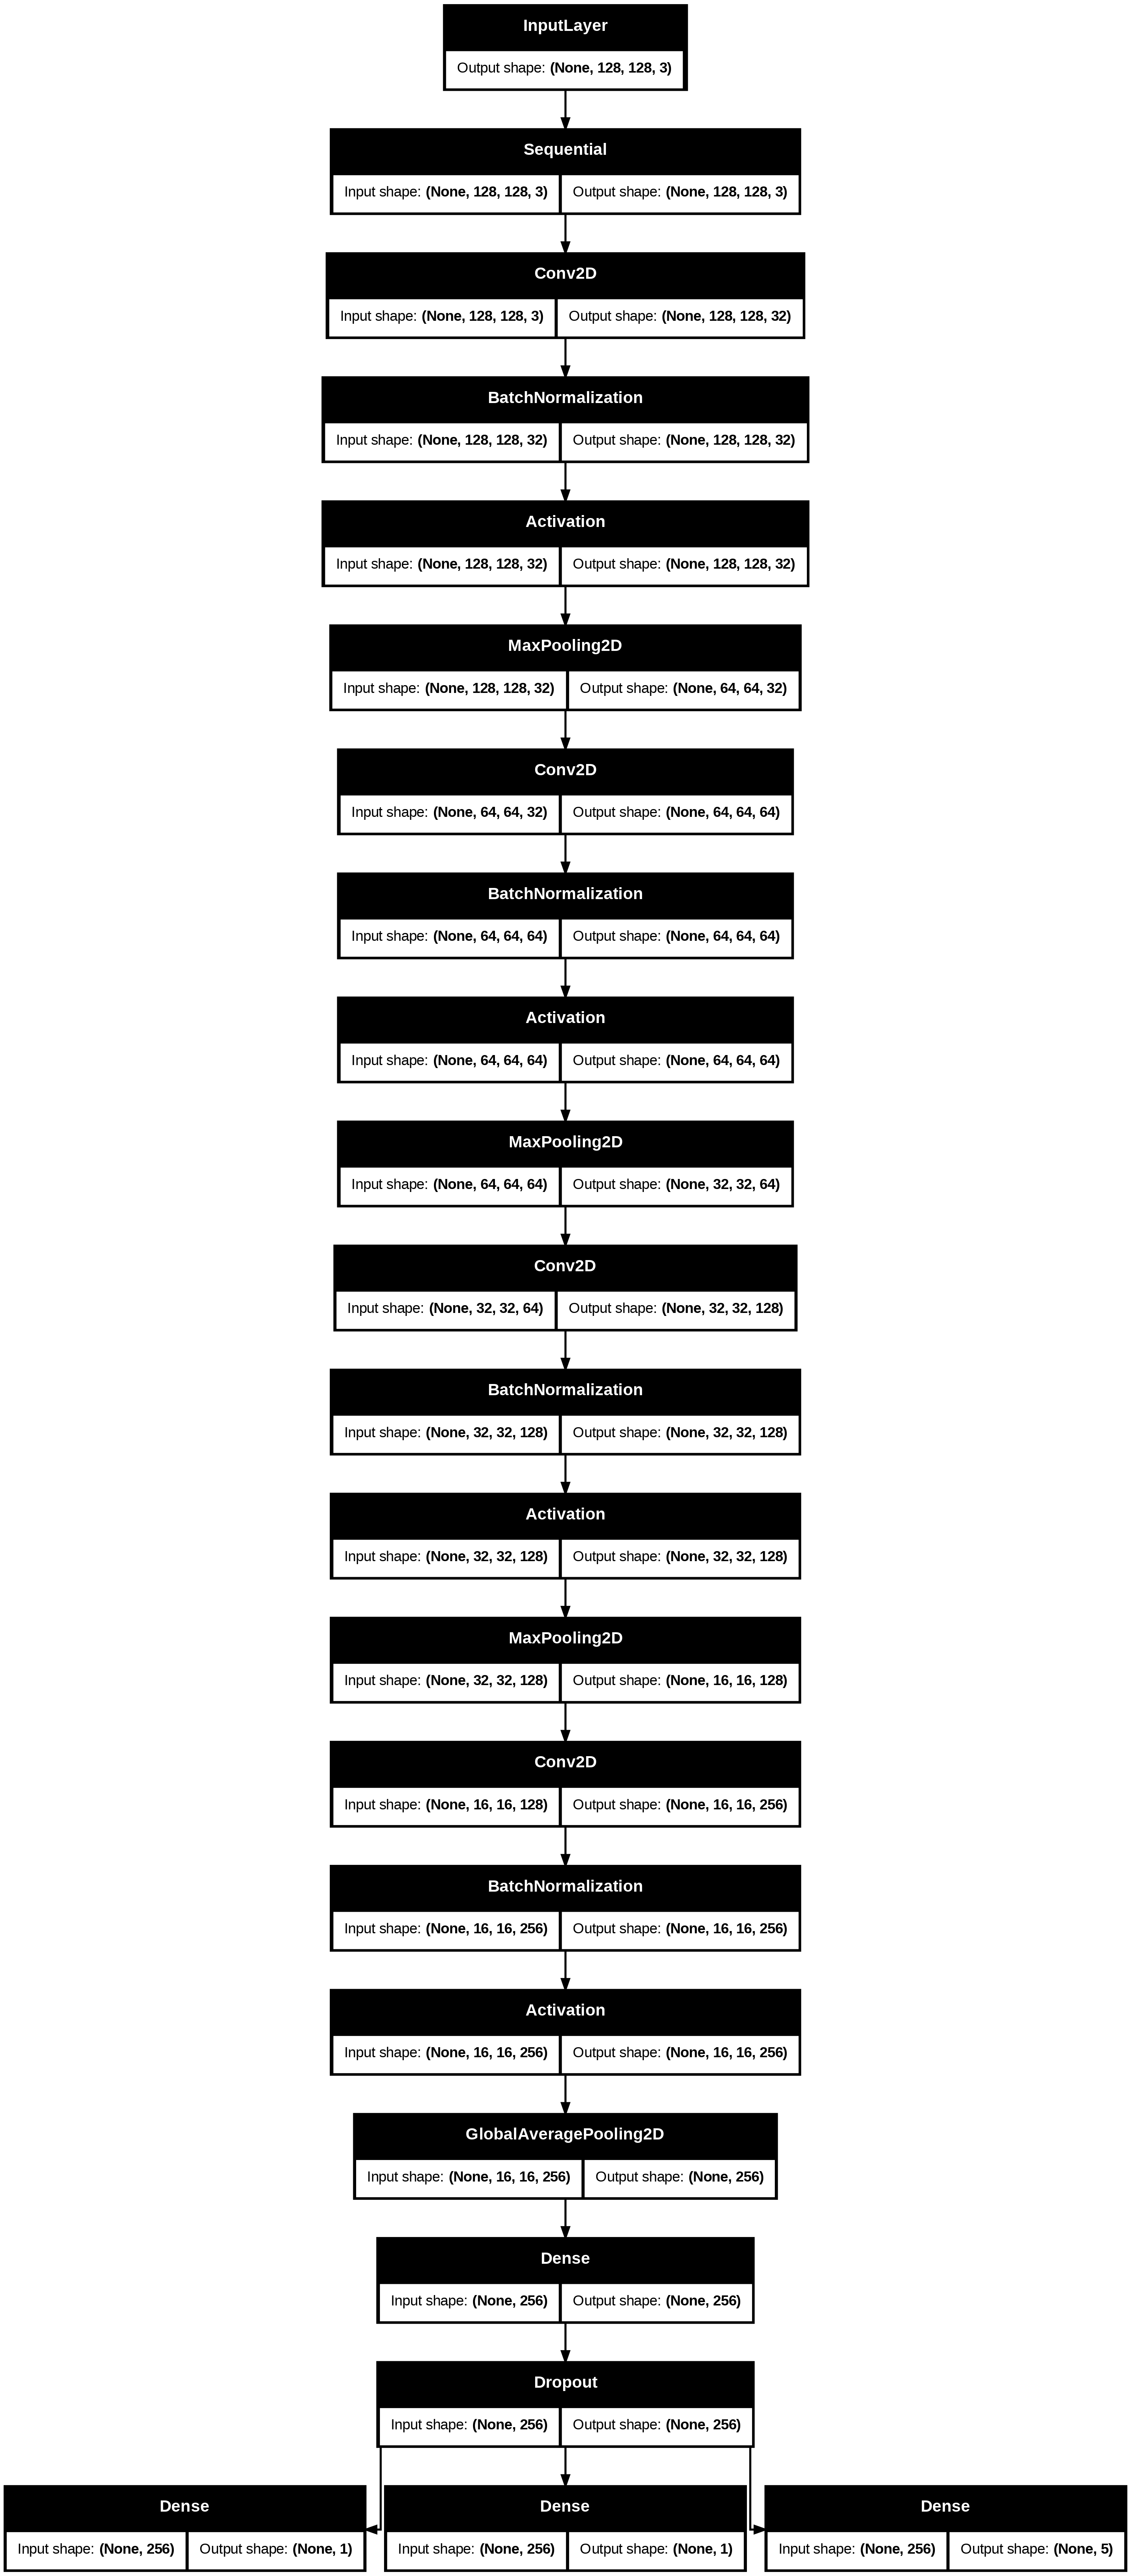

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
import keras
keras.utils.clear_session(free_memory=True)


In [18]:
from keras import layers, models, callbacks

def vgg_block(x, filters):
  #conv-conv-pool
  x = layers.Conv2D(filters, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters, (3,3), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.25)(x)

  return x

# Model 2 (VGG Inspired)
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = vgg_block(x, 32)
x = vgg_block(x, 64)
x = vgg_block(x, 128)
x = vgg_block(x, 256)
x = vgg_block(x, 512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# Age (Regression)
age_fcl = layers.Dense(256, activation='relu')(x)
age_output = layers.Dense(1, activation='sigmoid', name='age_output')(age_fcl)

# Gender (Classification)
gender_fcl = layers.Dense(64, activation='relu')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_fcl)

# Ethnicity (Classification)
ethnicity_fcl = layers.Dense(512, activation='relu')(x)
ethnicity_fcl = layers.Dropout(0.5)(ethnicity_fcl)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(ethnicity_fcl)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),

    loss={
        'age_output': 'mean_squared_error',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },

    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },

    loss_weights={
        'age_output': 1.0,
        'gender_output': 1.0,
        'ethnicity_output': 1.0
    }
)
print("Model compiled for 3 outputs.")

model.summary()

Model compiled for 3 outputs.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][

 Total params: 6,101,159 (23.27 MB)

 Trainable params: 6,097,191 (23.26 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='vgg_model.keras', monitor='val_loss', save_best_only=True)

# Training
print("Starting training")
history = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=[early_stopping, model_checkpoint])
print("Training complete.")

# Testing
print("\nEvaluating on unseen test data")
test_metrics = model.evaluate(test_df)
print(f"Test Metrics: {test_metrics}")

Starting training
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 66s 254ms/step - age_output_loss: 0.0388 - age_output_mean_absolute_error: 0.1514 - ethnicity_output_accuracy: 0.2805 - ethnicity_output_loss: 1.7177 - gender_output_accuracy: 0.5797 - gender_output_loss: 0.6811 - loss: 2.4376 - val_age_output_loss: 0.0315 - val_age_output_mean_absolute_error: 0.1468 - val_ethnicity_output_accuracy: 0.4250 - val_ethnicity_output_loss: 1.5784 - val_gender_output_accuracy: 0.5263 - val_gender_output_loss: 0.6889 - val_loss: 2.2979
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - age_output_loss: 0.0277 - age_output_mean_absolute_error: 0.1285 - ethnicity_output_accuracy: 0.3657 - ethnicity_output_loss: 1.4832 - gender_output_accuracy: 0.6669 - gender_output_loss: 0.6062 - loss: 2.1171 - val_age_output_loss: 0.0330 - val_age_output_mean_absolute_error: 0.1387 - val_ethnicity_output_accuracy: 0.3170 - val_ethnicity_output_loss: 1.7586 - val_gender_output_accuracy: 0.5265 - val_gender_output_

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
destination = '/content/drive/MyDrive/vgg_model.keras'
model.save(destination)

This VGG inspired model (with GAP) is clearly our best model

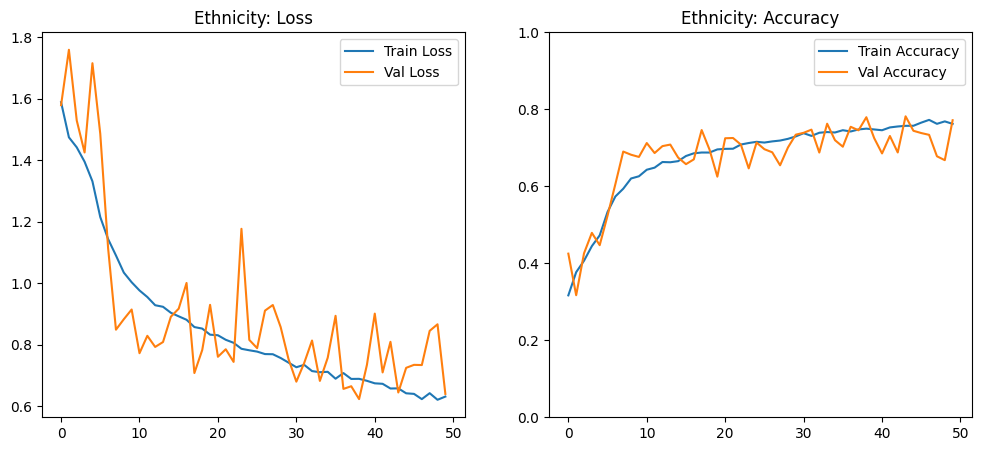

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['ethnicity_output_loss'], label='Train Loss')
plt.plot(history.history['val_ethnicity_output_loss'], label='Val Loss')
plt.title('Ethnicity: Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['ethnicity_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_ethnicity_output_accuracy'], label='Val Accuracy')
plt.title('Ethnicity: Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()

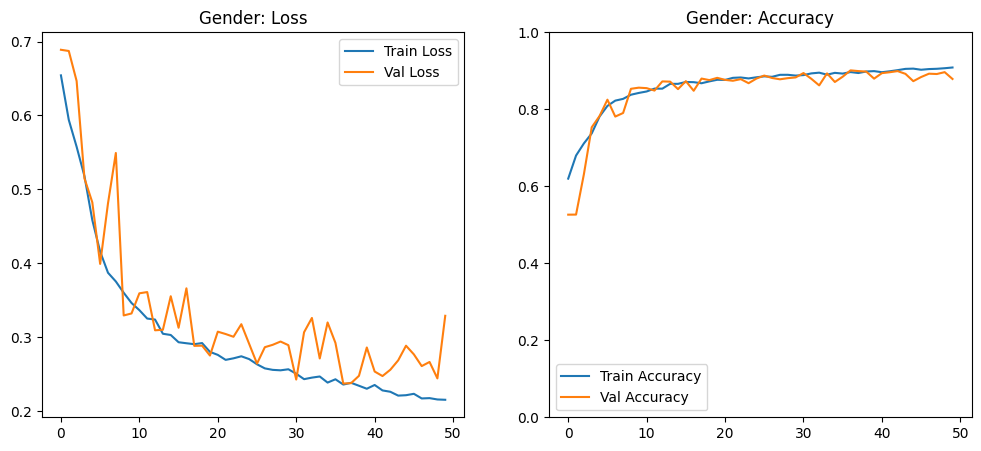

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['gender_output_loss'], label='Train Loss')
plt.plot(history.history['val_gender_output_loss'], label='Val Loss')
plt.title('Gender: Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Accuracy')
plt.title('Gender: Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.show()

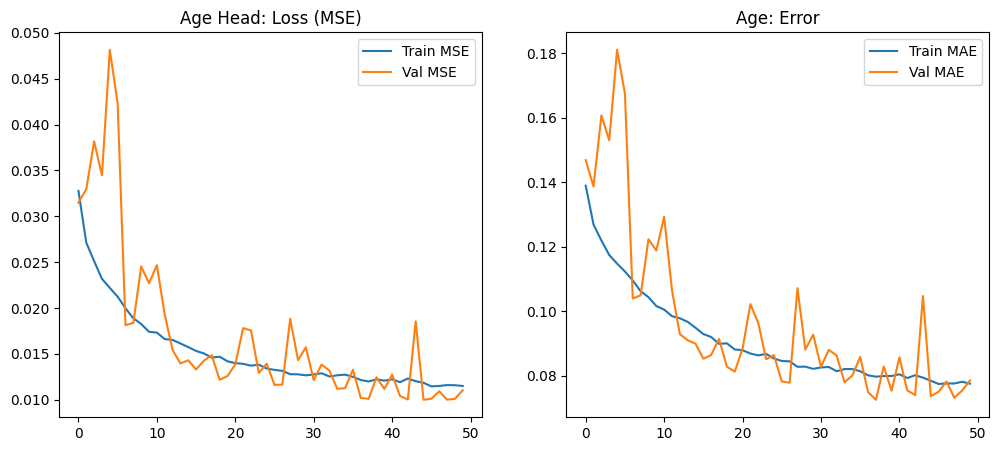

In [24]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_loss'], label='Train MSE')
plt.plot(history.history['val_age_output_loss'], label='Val MSE')
plt.title('Age Head: Loss (MSE)')
plt.legend()

# Subplot 2: Error (MAE)
plt.subplot(1, 2, 2) #
plt.plot(history.history['age_output_mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_age_output_mean_absolute_error'], label='Val MAE')
plt.title('Age: Error')
plt.legend()

plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Gender
              precision    recall  f1-score   support

        Male       0.93      0.88      0.91      2536
      Female       0.87      0.93      0.90      2205

    accuracy                           0.90      4741
   macro avg       0.90      0.90      0.90      4741
weighted avg       0.90      0.90      0.90      4741



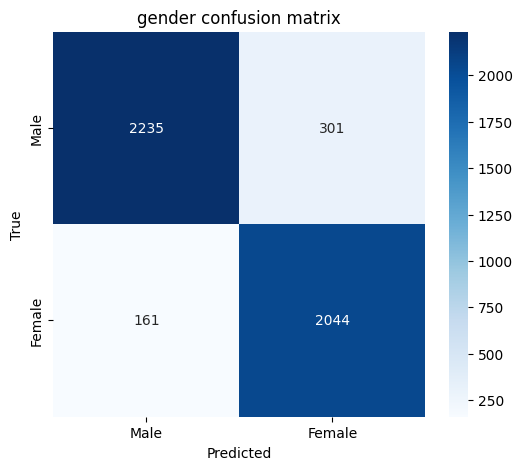

Ethnicity
              precision    recall  f1-score   support

       White       0.90      0.79      0.84      2016
       Black       0.83      0.86      0.84       905
       Asian       0.74      0.86      0.79       687
      Indian       0.83      0.62      0.71       795
      Others       0.28      0.52      0.37       338

    accuracy                           0.77      4741
   macro avg       0.72      0.73      0.71      4741
weighted avg       0.81      0.77      0.78      4741



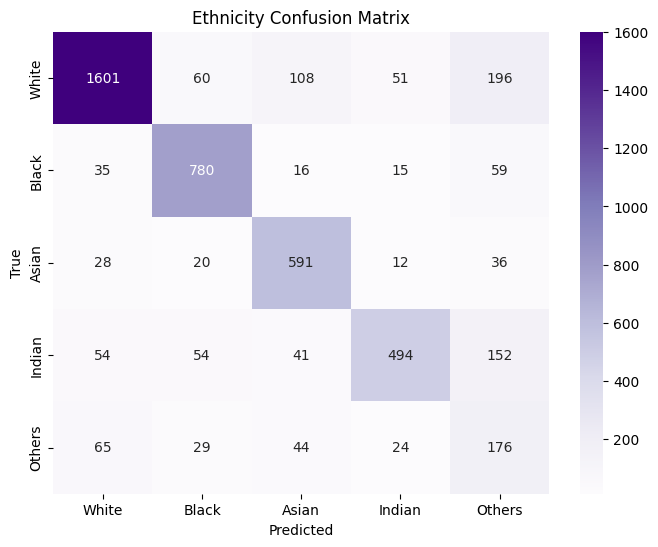

Age MAE: 9.7884


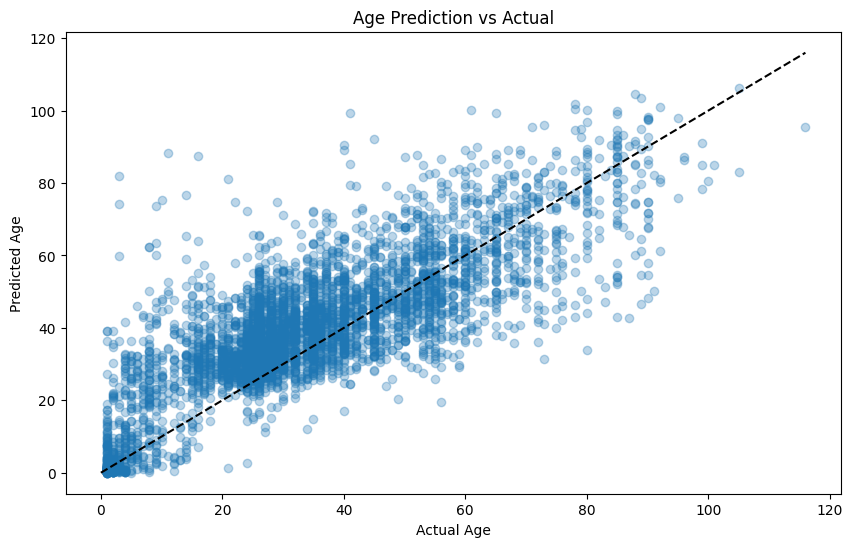

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
import keras

# Load model
model = keras.models.load_model('/content/vgg_model.keras')

# predictions
predictions = model.predict(test_df)
y_pred_age = predictions[0]
y_pred_gender = predictions[1]
y_pred_race = predictions[2]

# true labels from dataset
y_true_age = []
y_true_gender = []
y_true_race = []

for batch in test_df:
    _, labels, _ = batch
    y_true_age.extend(labels[0].numpy())
    y_true_gender.extend(labels[1].numpy())
    y_true_race.extend(labels[2].numpy())

# Process predictions
y_pred_gender_classes = (y_pred_gender > 0.5).astype("int32").flatten()
y_true_gender_classes = np.array(y_true_gender).astype("int32")

y_pred_race_classes = np.argmax(y_pred_race, axis=1)
y_true_race_classes = np.array(y_true_race).astype("int32")

y_pred_age_real = y_pred_age * 116
y_true_age_real = np.array(y_true_age) * 116

gender_map = ['Male', 'Female']
race_map = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Gender Analysis
print("Gender")
print(classification_report(y_true_gender_classes, y_pred_gender_classes, target_names=gender_map))

plt.figure(figsize=(6, 5))
cm_gender = confusion_matrix(y_true_gender_classes, y_pred_gender_classes)
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=gender_map, yticklabels=gender_map)
plt.title('gender confusion matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Ethnicity Analysis
print("Ethnicity")
print(classification_report(y_true_race_classes, y_pred_race_classes, target_names=race_map))

plt.figure(figsize=(8, 6))
cm_race = confusion_matrix(y_true_race_classes, y_pred_race_classes)
sns.heatmap(cm_race, annot=True, fmt='d', cmap='Purples', xticklabels=race_map, yticklabels=race_map)
plt.title('Ethnicity Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Age Analysis
mae = mean_absolute_error(y_true_age_real, y_pred_age_real)
print(f"Age MAE: {mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_true_age_real, y_pred_age_real, alpha=0.3)
plt.plot([0, 116], [0, 116], 'k--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction vs Actual')
plt.show()

In [25]:
from keras import layers, models
from keras.applications import MobileNetV2

# MobileNetV2
print("MobileNetV2 Transfer Learning model...")

# Load the pre-trained Base
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False,  weights='imagenet')
base_model.trainable = False

# Build our model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# data augmentation
x = data_augmentation(inputs)

x = layers.Rescaling(scale=2.0, offset=-1.0)(x)

# base model
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# connect base model to our original output fcls
# Age (Regression)
age_fcl = layers.Dense(256, activation='relu')(x)
age_output = layers.Dense(1, activation='sigmoid', name='age_output')(age_fcl)

# Gender (Classification)
gender_fcl = layers.Dense(64, activation='relu')(x)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_fcl)

# Ethnicity (Classification)
ethnicity_fcl = layers.Dense(512, activation='relu')(x)
ethnicity_fcl = layers.Dropout(0.5)(ethnicity_fcl)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity_output')(ethnicity_fcl)

model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        'age_output': 'mean_squared_error',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age_output': 'mean_absolute_error',
        'gender_output': 'accuracy',
        'ethnicity_output': 'accuracy'
    },
    loss_weights={
        'age_output': 1.0,
        'gender_output': 1.0,
        'ethnicity_output': 1.0
    }
)

model.summary()


MobileNetV2 Transfer Learning model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ rescaling[0][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     81,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ethnicity_output    │ (None, 5)         │      2,565 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,326,663 (12.69 MB)

 Trainable params: 1,068,679 (4.08 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
# Training
print("starting training with MobileNetV2 base...")
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_mobilenet = keras.callbacks.ModelCheckpoint(filepath='model_mobilenet.keras', monitor='val_loss', save_best_only=True)
history_mobilenet = model.fit(train_df, epochs=30, validation_data=val_df, callbacks=[early_stopping, model_checkpoint_mobilenet])


starting training with MobileNetV2 base...
Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - age_output_loss: 0.0177 - age_output_mean_absolute_error: 0.1018 - ethnicity_output_accuracy: 0.3659 - ethnicity_output_loss: 1.5837 - gender_output_accuracy: 0.7201 - gender_output_loss: 0.5517 - loss: 2.1533 - val_age_output_loss: 0.0133 - val_age_output_mean_absolute_error: 0.0904 - val_ethnicity_output_accuracy: 0.5520 - val_ethnicity_output_loss: 1.1930 - val_gender_output_accuracy: 0.7798 - val_gender_output_loss: 0.4638 - val_loss: 1.6643
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - age_output_loss: 0.0138 - age_output_mean_absolute_error: 0.0903 - ethnicity_output_accuracy: 0.4799 - ethnicity_output_loss: 1.3142 - gender_output_accuracy: 0.7913 - gender_output_loss: 0.4611 - loss: 1.7891 - val_age_output_loss: 0.0128 - val_age_output_mean_absolute_error: 0.0886 - val_ethnicity_output_accuracy: 0.5910 - val_ethnicity_output_loss: 1.1166 - val_gender_output_accuracy: 0.80

In [28]:
from keras import layers, models, optimizers

print("Loading best model from initial training...")
model = keras.models.load_model('model_mobilenet.keras')

# Un-freeze the top layers of the model
base_model = None
for layer in model.layers:
    if 'mobilenet' in layer.name:
        base_model = layer
        break

if base_model:
  base_model.trainable = True

fine_tune_at = 100
# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  #/10 of the earlier learning rate
    loss={'age_output': 'mean_squared_error', 'gender_output': 'binary_crossentropy', 'ethnicity_output': 'sparse_categorical_crossentropy' },
    metrics={'age_output': 'mean_absolute_error', 'gender_output': 'accuracy', 'ethnicity_output': 'accuracy'},
    loss_weights={'age_output': 1.0, 'gender_output': 1.0, 'ethnicity_output': 1.0}
)
model.summary()

checkpoint_finetune = keras.callbacks.ModelCheckpoint(filepath='mobilenet_finetuned.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

print("Starting finetuning")
history_finetuned = model.fit(train_df, epochs=50, validation_data=val_df, callbacks=[early_stopping, checkpoint_finetune, reduce_lr])

Loading best model from initial training...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ rescaling[0][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     81,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ethnicity_output    │ (None, 5)         │      2,565 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,326,663 (12.69 MB)

 Trainable params: 2,930,119 (11.18 MB)

 Non-trainable params: 396,544 (1.51 MB)

Starting finetuning
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - age_output_loss: 0.0296 - age_output_mean_absolute_error: 0.1320 - ethnicity_output_accuracy: 0.4896 - ethnicity_output_loss: 1.6914 - gender_output_accuracy: 0.6800 - gender_output_loss: 0.6095 - loss: 2.3304
Epoch 1: val_loss improved from inf to 1.64422, saving model to mobilenet_finetuned.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - age_output_loss: 0.0296 - age_output_mean_absolute_error: 0.1320 - ethnicity_output_accuracy: 0.4896 - ethnicity_output_loss: 1.6907 - gender_output_accuracy: 0.6802 - gender_output_loss: 0.6092 - loss: 2.3295 - val_age_output_loss: 0.0135 - val_age_output_mean_absolute_error: 0.0882 - val_ethnicity_output_accuracy: 0.5248 - val_ethnicity_output_loss: 1.1995 - val_gender_output_accuracy: 0.7990 - val_gender_output_loss: 0.4420 - val_loss: 1.6442 - learning_rate: 1.0000e-05
Epoch 2/50
222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - age_output_loss: 0.0199 - age_output_mean_abso

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - age_output_loss: 0.0099 - age_output_mean_absolute_error: 0.0740 - ethnicity_output_accuracy: 0.7547 - ethnicity_output_loss: 0.7133 - gender_output_accuracy: 0.8968 - gender_output_loss: 0.2606 - loss: 0.9837
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - age_output_loss: 0.0131 - age_output_mean_absolute_error: 0.0852 - ethnicity_output_accuracy: 0.7642 - ethnicity_output_loss: 0.6652 - gender_output_accuracy: 0.8965 - gender_output_loss: 0.2447 - loss: 0.9227

VGG from Scratch Model Test Results
Ethnicity Accuracy: 0.7682
Gender Accuracy:    0.9026
Age MAE:       0.0844

MobileNetV2 Test Results
Ethnicity Accuracy: 0.7604
Gender Accuracy:    0.9009
Age MAE:       0.0724


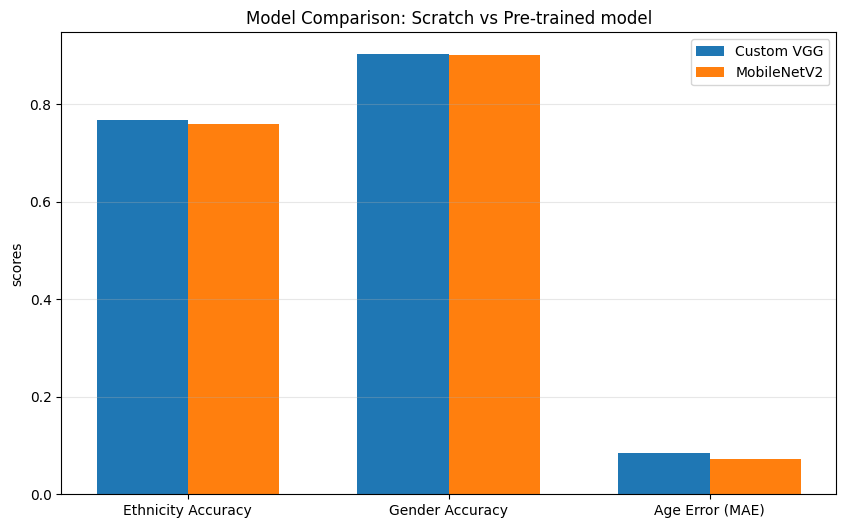

In [30]:
import pandas as pd
finetuned_model = keras.models.load_model('/content/mobilenet_finetuned.keras')
vgg_model = keras.models.load_model('/content/vgg_model.keras')


mobilenet_results = finetuned_model.evaluate(test_df, return_dict=True)
vgg_results = vgg_model.evaluate(test_df, return_dict=True)

print("\nVGG from Scratch Model Test Results")
print(f"Ethnicity Accuracy: {vgg_results['ethnicity_output_accuracy']:.4f}")
print(f"Gender Accuracy:    {vgg_results['gender_output_accuracy']:.4f}")
print(f"Age MAE:       {vgg_results['age_output_mean_absolute_error']:.4f}")

print("\nMobileNetV2 Test Results")
print(f"Ethnicity Accuracy: {mobilenet_results['ethnicity_output_accuracy']:.4f}")
print(f"Gender Accuracy:    {mobilenet_results['gender_output_accuracy']:.4f}")
print(f"Age MAE:       {mobilenet_results['age_output_mean_absolute_error']:.4f}")


metrics = ['Ethnicity Accuracy', 'Gender Accuracy', 'Age Error (MAE)']
vgg_scores = [
    vgg_results['ethnicity_output_accuracy'],
    vgg_results['gender_output_accuracy'],
    vgg_results['age_output_mean_absolute_error']
]
mobilenet_scores = [
    mobilenet_results['ethnicity_output_accuracy'],
    mobilenet_results['gender_output_accuracy'],
    mobilenet_results['age_output_mean_absolute_error']
]

# let's plot these metrics
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar([i - width/2 for i in x], vgg_scores, width, label='VGG (from Scratch)')
rects2 = ax.bar([i + width/2 for i in x], mobilenet_scores, width, label='MobileNetV2')

ax.set_ylabel('scores')
ax.set_title('Model Comparison: Scratch vs Pre-trained model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.grid(True, axis='y', alpha=0.3)
plt.show()